# Music Generation

In [this project](https://github.com/RasmusML/musicHMM), we will generate music notes using hidden markov models. The models are trained on Bach pieces.

We will explore X models. The first model is a standard HMM-1 and implemented from scratch. The remaning X models are implemented in the probablistic framework Pyro, which simplifies implementing the model - as the procedure (a modified Baum welch implementation) used to optimize the models weights does not need to be implemented as well.
Instead of using Pyro, we could had implemented the models in pyTorch, since the backpropogation algorithm can be used to optimize the weights - but I opted for Pyro.

Overview of the models:
- HMM-0: single-note, fixed-length
- HMM-1: multiple notes, fixed-length

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam, ClippedAdam

from utils import *
from hmm import HMM

np.random.seed(0)

## Data exploration

The JSB chorales are a set of short, four-voice pieces of music well-noted for their stylistic homogeneity. The chorales were originally composed by Johann Sebastian Bach in the 18th century. He wrote them by first taking pre-existing melodies from contemporary Lutheran hymns and then harmonising them to create the parts for the remaining three voices. The version of the dataset used canonically in representation learning contexts consists of 382 such chorales. These pieces are stored in MIDI format.

Let"s load the data.

In [3]:
data = load_jsb_chorales()

Let's shuffle the data.

In [4]:
idxs = np.arange(len(data))
np.random.shuffle(idxs)
data = [data[i] for i in idxs]

Let's look at the range of the notes.

In [5]:
notes = [note for chorale in data for t_note in chorale for note in t_note]
lowest_note = np.min(notes)
highest_note = np.max(notes)

print(f"Lowest note: {lowest_note}")
print(f"Highest note: {highest_note}")

Lowest note: 23
Highest note: 76


The notes are indexed from 1 to 88, where 1 is the lowest note on the piano and 88 is the highest note. The note 0 is interpreted as no note being played. 

Let's look at the distributions.

Text(0.5, 1.0, 'Histogram of notes')

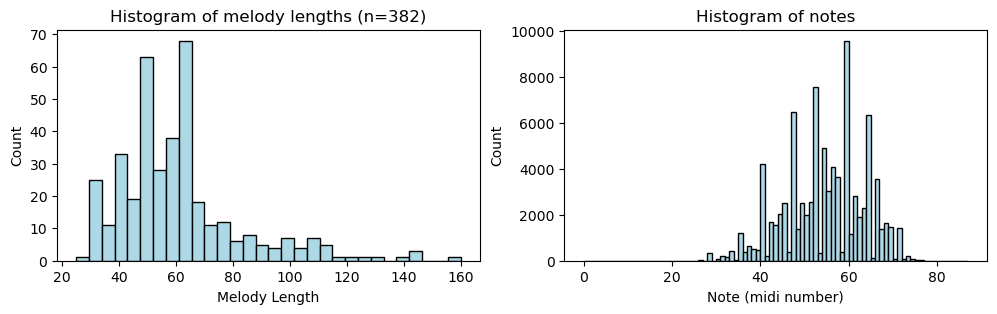

In [6]:
lengths = [len(song) for song in data]

fig, axes = plt.subplots(figsize=(12,3), ncols=2)
ax = axes[0]
ax.hist(lengths, bins=30, color="lightblue", edgecolor="black")
ax.set_xlabel("Melody Length")
ax.set_ylabel("Count")
ax.set_title(f"Histogram of melody lengths (n={len(data)})") 

ax = axes[1]
notes = [note for chorale in data for t_note in chorale for note in t_note]
ax.hist(notes, bins=range(0, 88), color="lightblue", edgecolor="black")
ax.set_xlabel("Note (midi number)")
ax.set_ylabel("Count")
ax.set_title("Histogram of notes")

In [7]:
# @TODO: histogram of intervals (difference between consecutive notes)
# @TODO: 2d heatmap of absolute jumps between notes?

Let's listen to an example melody.

In [8]:
x_example = data[0]
write_mp3(x_example, "out/example_all.mp3")

In [9]:
audio_widget("out/example_all.mp3")

Let's split the data into training, validation and test set.

In [10]:
seqs_train_ = data[:290]
seqs_val_   = data[290:330]
seqs_test_  = data[330:]

In [11]:
print(f"Number of sequences in train: {len(seqs_train_)} ({len(seqs_train_) / len(data) * 100:.2f}%)")
print(f"Number of sequences in val: {len(seqs_val_)} ({len(seqs_val_) / len(data) * 100:.2f}%)")
print(f"Number of sequences in test: {len(seqs_test_)} ({len(seqs_test_) / len(data) * 100:.2f}%)")

Number of sequences in train: 290 (75.92%)
Number of sequences in val: 40 (10.47%)
Number of sequences in test: 52 (13.61%)


# Single note

### Data Preprocessing

Let's only look at the top voice for now.

In [12]:
def extract_top_part(data):
    single_data = []

    for sequence in data:
        notes = [[chords[0]] if len(chords) > 0 else [0] for chords in sequence]
        single_data.append(notes)

    return single_data

In [13]:
seqs_train = extract_top_part(seqs_train_)
seqs_val   = extract_top_part(seqs_val_)
seqs_test  = extract_top_part(seqs_test_)

Let's listen to the sound now.

In [14]:
x_examples = seqs_train[0]

write_mp3(x_examples, "out/example_single.mp3")

audio_widget("out/example_single.mp3")

### HMM-0

A simple HMM model has already been implemented many times in the past. Nevertheless, we will implement it from scratch again. The implementation uses log probabilities to avoid numerical underflow. The model is trained using the Baum-Welch algorithm, and tests have been created to verify the correctness of the implementation. The viterbi algorithm for predicing the most plausible hidden sequence has also been implemented and tested.

@TODO: math mode forward + backward formula?

In [15]:
x_train = np.array([note[0] for song in seqs_train for note in song])
lengths = np.array([len(song) for song in seqs_train])

In [16]:
n_iter = 40

model = HMM(n_hidden=4, n_obs=highest_note+1)
model.fit(x_train, lengths, n_iter=n_iter)

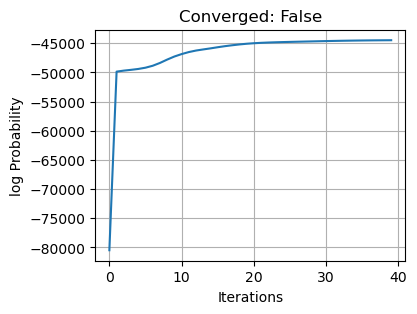

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(model._history)
ax.set_title(f"Converged: {len(model._history) < n_iter}")
ax.set_xlabel("Iterations")
ax.set_ylabel("log Probability")
ax.grid()

We ignore the validation and test set for this model (and only this model) to keep the implementation simple.

In [18]:
x_sample, state_sequence = model.sample(50)

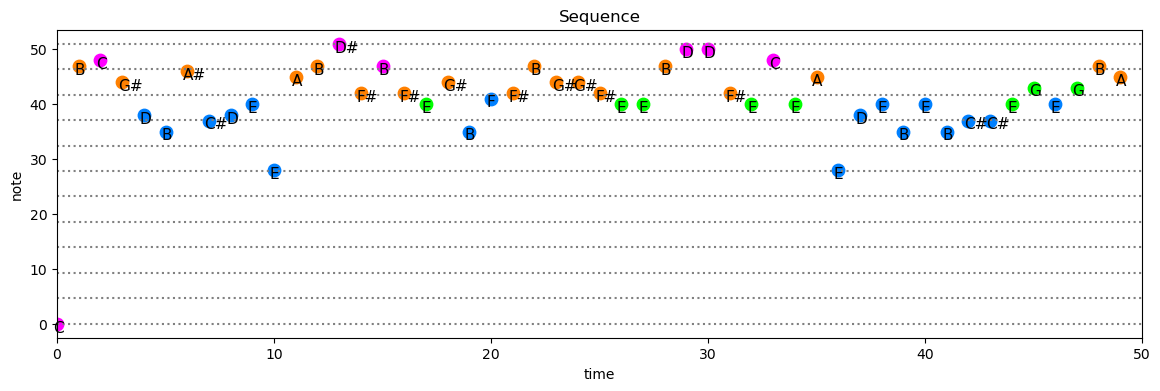

In [19]:
plot_sequence(idx_to_onehot(x_sample), state_sequence)

In [20]:
write_mp3([[note] for note in x_sample], "out/hmm0_example.mp3")

audio_widget("out/hmm0_example.mp3")

## Multiple notes

### Data preprocessing

Let's now use up to 4 notes per time step.

In [21]:
seqs_train = seqs_train_
seqs_val   = seqs_val_
seqs_test  = seqs_test_

### HMM-1

Let's jump directly to pyro implementations and this time also evalulate the model on the validation set.

$$
[t-1] --> x[t] --> x[t+1]
        |        |         |
        V        V         V
     y[t-1]     y[t]     y[t+1]
$$

@TODO: bernoulli vs categorial

In [22]:
def model_1(sequences, lengths, data_dim, hidden_dim, batch_size=None, include_prior=True):
    if sequences is not None:
        num_sequences, max_length, _ = map(int, sequences.shape)
    else:
        # when sampling, sample a single sequence
        num_sequences = 1
        max_length = lengths.max()

    assert lengths.shape == (num_sequences,)
    assert lengths.max() <= max_length
    
    with poutine.mask(mask=include_prior):
        probs_x = pyro.sample(
            "probs_x",
            dist.Dirichlet(0.9 * torch.eye(hidden_dim) + 0.1).to_event(1),
        )
        probs_y = pyro.sample(
            "probs_y",
            dist.Beta(0.1, 0.9).expand([hidden_dim, data_dim]).to_event(2),
        )
    
    tones_plate = pyro.plate("tones", data_dim, dim=-1)
    
    x_seq = torch.zeros(max_length, dtype=torch.long)
    y_seq = torch.zeros(max_length, data_dim)

    with pyro.plate("sequences", num_sequences, batch_size, dim=-2) as batch:
        lens = lengths[batch]
        x = 0
        for t in pyro.markov(range(lens.max())):
            with poutine.mask(mask=(t < lens).unsqueeze(-1)):
                x = pyro.sample(
                    "x_{}".format(t),
                    dist.Categorical(probs_x[x]),
                    infer={"enumerate": "parallel"},
                )
                x_seq[t] = x[0]

                with tones_plate:
                    y_seq[t] = pyro.sample(
                        "y_{}".format(t),
                        dist.Bernoulli(probs_y[x.squeeze(-1)]),
                        obs=sequences[batch, t] if sequences is not None else None,
                    )[0]

    return y_seq, x_seq

In [23]:
"""
pyro.render_model(
    model1,
    model_args=(sequences, lengths, data_dim, hidden_dim,),
    #render_distributions=True,
)
"""

'\npyro.render_model(\n    model1,\n    model_args=(sequences, lengths, data_dim, hidden_dim,),\n    #render_distributions=True,\n)\n'

In [35]:
def train(model, seqs_train, seqs_val, seqs_test, hidden_dim, batch_size, num_steps, lr=0.1, step_every=10):
    # prepare data
    sequences_train = torch.from_numpy(idx_to_onehot_multi(seqs_train)).float()
    lengths_train = torch.tensor([len(song) for song in seqs_train])

    sequences_val = torch.from_numpy(idx_to_onehot_multi(seqs_val)).float()
    lengths_val = torch.tensor([len(song) for song in seqs_val])

    sequences_test = torch.from_numpy(idx_to_onehot_multi(seqs_test)).float()
    lengths_test = torch.tensor([len(song) for song in seqs_test])

    # setup optimizer and inference algorithm
    pyro.set_rng_seed(42)
    pyro.clear_param_store()

    guide = AutoDelta(poutine.block(model, expose_fn=lambda msg: msg["name"].startswith("probs")))
    optim = ClippedAdam({"lr": lr})
    elbo = TraceEnum_ELBO(max_plate_nesting=2)
    svi = SVI(model, guide, optim, elbo)

    data_dim = sequences_train.shape[-1]

    train_losses = []
    val_losses = []

    for step in range(num_steps):

        # take a gradient step
        svi.step(sequences_train, lengths_train, data_dim=data_dim, hidden_dim=hidden_dim, batch_size=batch_size)

        # compute loss
        with torch.no_grad():
            loss_train = elbo.loss(model, guide, sequences_train, lengths_train, data_dim=data_dim, hidden_dim=hidden_dim, batch_size=batch_size)
            loss_train /= sequences_train.shape[0]

            loss_validation = elbo.loss(model, guide, sequences_val, lengths_val, data_dim=data_dim, hidden_dim=hidden_dim, batch_size=batch_size)
            loss_validation /= sequences_val.shape[0]

            train_losses.append(loss_train)
            val_losses.append(loss_validation)
            
        if step_every != -1 and step % step_every == 0:
            print(f"Step {step} - Train loss: {loss_train:.2f} - Validation loss: {loss_validation:.2f}")

    loss_test = elbo.loss(model, guide, sequences_test, lengths_test, data_dim=data_dim, hidden_dim=hidden_dim, batch_size=batch_size)
    loss_test /= sequences_test.shape[0]

    return {
        "model": model,
        "guide": guide,
        "data_dim": data_dim,

        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_loss": loss_test,
    }

In [25]:
model = model_1
hidden_dim = 6

In [26]:
train_result = train(model, seqs_train, seqs_val, seqs_test, hidden_dim=hidden_dim, batch_size=12, num_steps=200, lr=0.1)

Step 0 - Train loss: 1358.84 - Validation loss: 1186.33
Step 10 - Train loss: 1273.06 - Validation loss: 1050.03
Step 20 - Train loss: 987.73 - Validation loss: 963.33
Step 30 - Train loss: 915.37 - Validation loss: 750.64
Step 40 - Train loss: 717.53 - Validation loss: 587.19
Step 50 - Train loss: 649.14 - Validation loss: 749.69
Step 60 - Train loss: 678.85 - Validation loss: 585.29
Step 70 - Train loss: 636.04 - Validation loss: 494.62
Step 80 - Train loss: 641.62 - Validation loss: 538.05
Step 90 - Train loss: 526.77 - Validation loss: 494.08
Step 100 - Train loss: 565.64 - Validation loss: 574.79
Step 110 - Train loss: 551.30 - Validation loss: 468.88
Step 120 - Train loss: 586.26 - Validation loss: 577.56
Step 130 - Train loss: 514.52 - Validation loss: 464.01
Step 140 - Train loss: 576.43 - Validation loss: 429.23
Step 150 - Train loss: 525.66 - Validation loss: 504.54
Step 160 - Train loss: 657.28 - Validation loss: 426.53
Step 170 - Train loss: 647.95 - Validation loss: 458.20

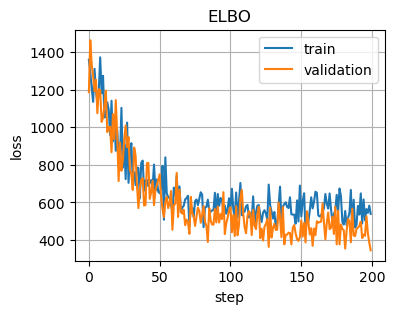

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(train_result["train_losses"], label="train")
ax.plot(train_result["val_losses"], label="validation")
ax.set_title("ELBO")
ax.set_xlabel("step")
ax.set_ylabel("loss")
ax.legend()
ax.grid()

In [28]:
print(f"Test loss: {train_result['test_loss']:.2f}")

Test loss: 439.45


In [29]:
def sample(model, guide, n_samples, **model_kwargs):
    trained_model = poutine.condition(model, guide())
    posterior_samples, posterior_hidden = trained_model(None, torch.tensor([n_samples]), **model_kwargs)

    posterior_samples = posterior_samples.numpy()
    posterior_hidden = posterior_hidden.numpy()

    return posterior_samples, posterior_hidden

In [30]:
model, guide, data_dim = train_result["model"], train_result["guide"], train_result["data_dim"]

posterior_samples, posterior_hidden = sample(model, guide, n_samples=100, data_dim=data_dim, hidden_dim=hidden_dim)

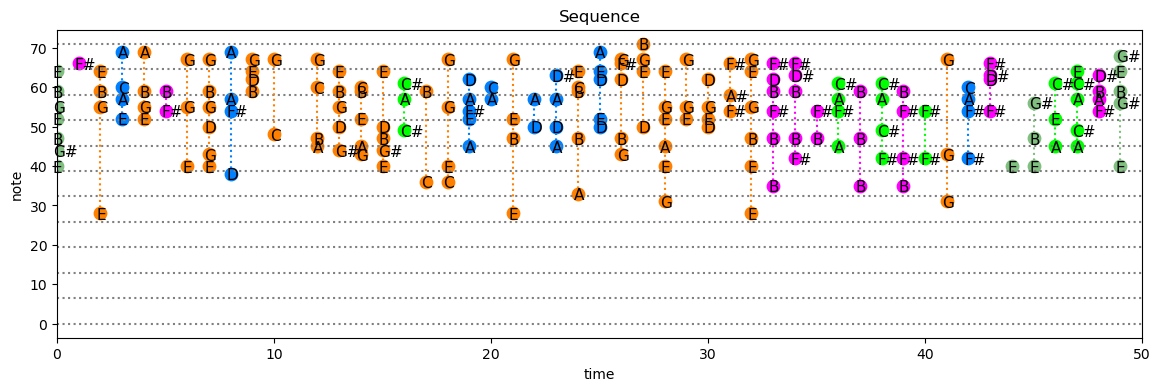

In [31]:
n = 50

plot_sequence(posterior_samples[:n], posterior_hidden[:n])

In [32]:
ps = posterior_samples > 0.5

np.sum(ps)

387

In [33]:
x_samples = posterior_samples.astype(int)
idx_sequence = [one_hot_to_idx(sequence) for sequence in x_samples]

In [34]:
x_example = idx_sequence

write_mp3(x_example, "out/hmm1_example.mp3")
audio_widget("out/hmm1_example.mp3")

### HMM-2

## Conclusion

- fixed-duration vs. variable duration notes.